# Experimentation, Non-Compliance and Instrumental Variables with PyMC

In this notebook we present an example of how to use PyMC to estimate the effect of a treatment in an experiment where there is non-compliance through the use of instrumental variables. By non-compliance we means that the treatment assignment does not guarantee that the treatment is actually received by the treated. The main challenge is that we can nos simply estimate the treatment effect as a difference in means since the non-compliance mechanism is most of the times not random and may introduce confounders. For a more detailed discussion of the problem see [Chapter 9](https://matheusfacure.github.io/python-causality-handbook/09-Non-Compliance-and-LATE.html) in the (amazing!) book [*Causal Inference for The Brave and True*](https://matheusfacure.github.io/python-causality-handbook/landing-page.html) by [Matheus Facure Alves](https://github.com/matheusfacure). One very common tool to tackle such problem are instrumental variables (see [Chapter 8](https://matheusfacure.github.io/python-causality-handbook/08-Instrumental-Variables.html)) for a nice introduction. In essence, we can use the variant assignment as an instrument to control for confounders introduced by the non-compliance mechanism. To illustrate the concepts we are going to use the example worked out in Matheus' book (for a simulated example see [here](https://dpananos.github.io/posts/2023-02-11-iv-risk-ratio/)). Ok! So why bother to present the same example? Well, we are going to do it the bayesian way 😄 ! The main motivation is to include prior experiments information to have a more precise and informed estimate as described in the great blog post [Bayesian Instrumental variables (with a hierarchical prior) in Stan](https://khakieconomics.github.io/2017/11/26/Bayesian_iv.html) by [Jim Savage](https://khakieconomics.github.io/about/). For a great introduction to bayesian instrumental variables see the article [Bayesian instrumental variables: priors and likelihoods](https://hedibert.org/wp-content/uploads/2013/12/lopes-polson-ER.pdf) by Hedibert F. Lopes and Nicholas G. Polson.
In the first part of this notebook we replicate the example using PyMC and in the second part we extend it to include a hierarchical prior to encode previous experiments data (If you are Stan user I strongly recommend to read Jim's blog in parallel). 

## Prepare Notebook

In [1]:
import os
import arviz as az
import graphviz as gr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pymc.sampling_jax
import pytensor.tensor as pt
import seaborn as sns

from linearmodels.iv import IV2SLS

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.10/site-packages/pymc/sampling/jax.py:39: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


In [2]:
seed: int = sum(map(ord, "instrumental_variables"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

## Read Data

We read the `app_engagement_push.csv` data directly from the repository.

In [3]:
root_path = "https://raw.githubusercontent.com/matheusfacure/python-causality-handbook/master/causal-inference-for-the-brave-and-true/data/"
data_path = os.path.join(root_path, "app_engagement_push.csv")

df = pd.read_csv(data_path)

n = df.shape[0]

df.head()

,in_app_purchase,push_assigned,push_delivered
0,47,1,1
1,43,1,0
2,51,1,1
3,49,0,0
4,79,0,0


Here we have data regarding in-app purchases from an experiment. The columns `push_assigned` and `push_received` indicate whether the user was assigned to the treatment group and whether the user actually received the push notification.

## EDA

First, let's do an initial EDA to get a sense of the data. First, we count how many users received the push notification when assigned.

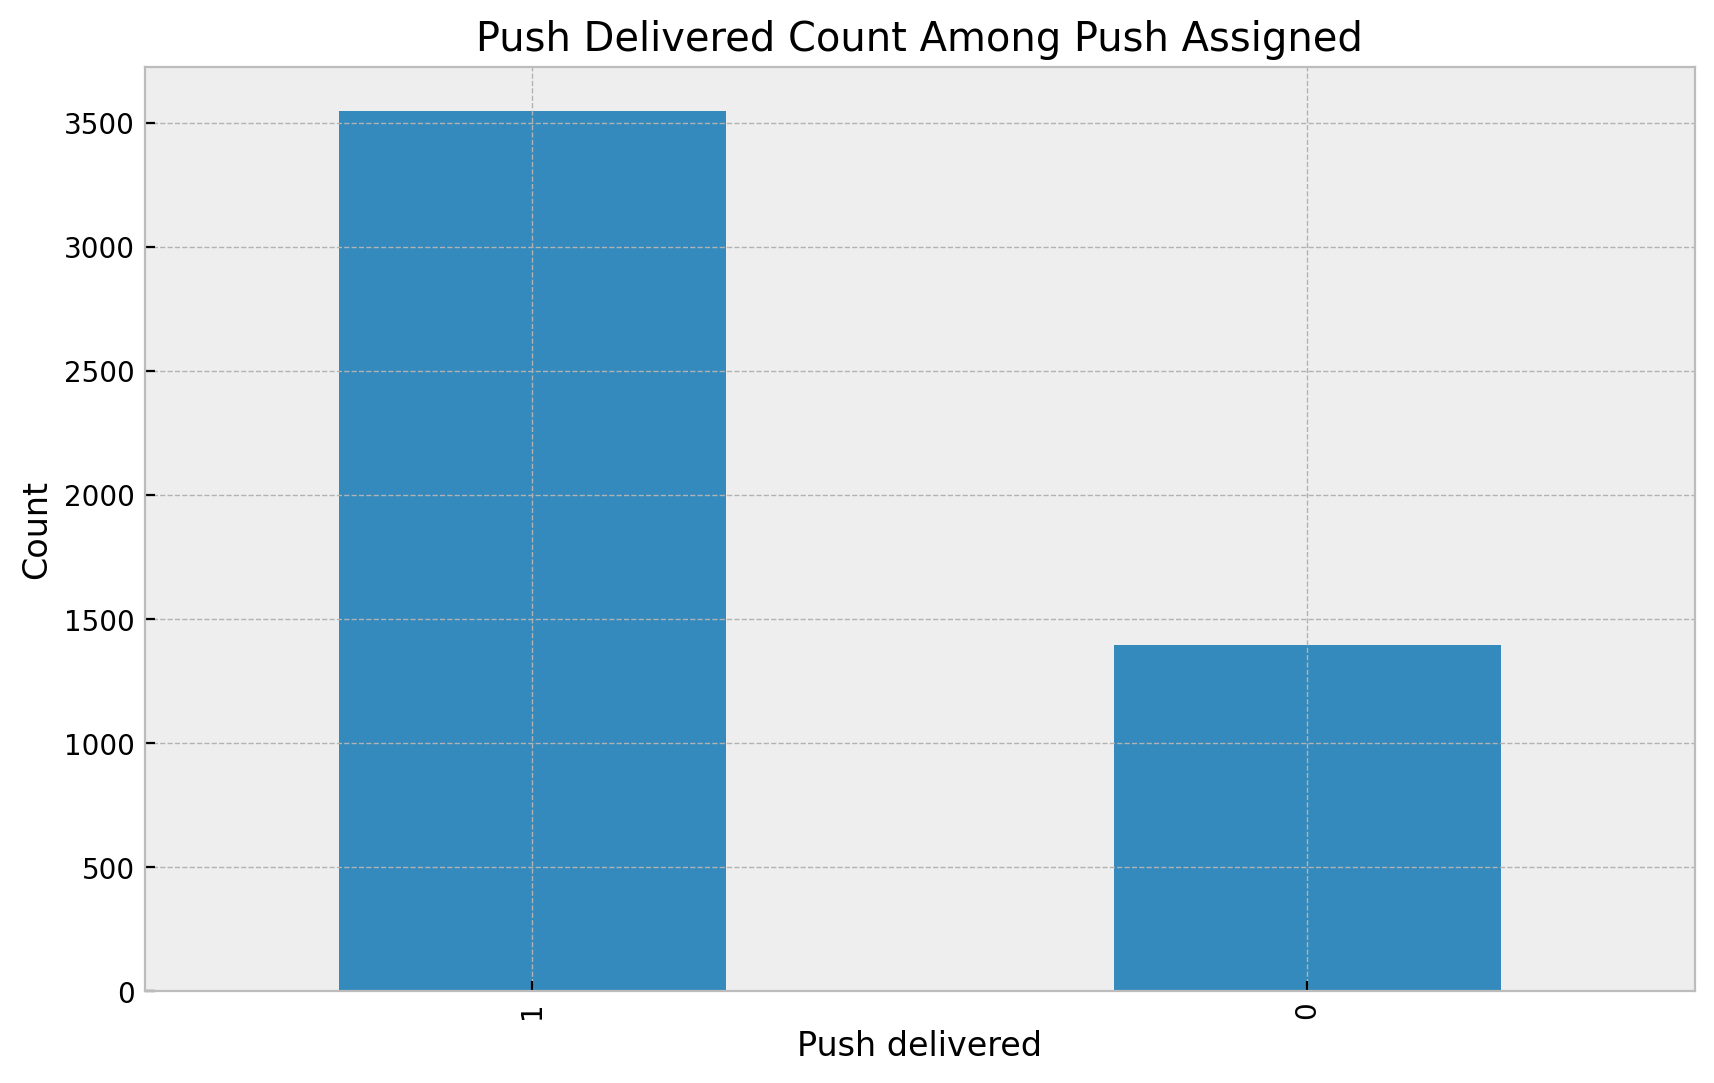

In [4]:
fig, ax = plt.subplots(figsize=(10, 6))
df.query("push_assigned == 1")["push_delivered"].value_counts().plot(kind="bar", ax=ax)
ax.set(title="Push Delivered Count Among Push Assigned", xlabel="Push delivered", ylabel="Count");

We see that roughly $30%$ of users which were assigned to the push did not get it. What could be the reason? Well, Matheus suggest this could be related to the fact users with old phones are less likely to receive the push notification. This naturally induces a bias if we analyze the effect of the push notification on purchases by filtering out only the ones that get it as these users are more likely to have higher income (new phones) that the control. Think about it in the context of the potential outcomes 😉. Here is the DAG we are going to use to model the problem.

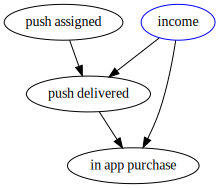

In [5]:
g = gr.Digraph()

g.edge("push assigned", "push delivered")
g.edge("push delivered", "in app purchase")
g.edge("income", "in app purchase")
g.edge("income", "push delivered")
g.node("income", color="blue")
g

We can compare the `in_app_purchase` distribution between the two groups.

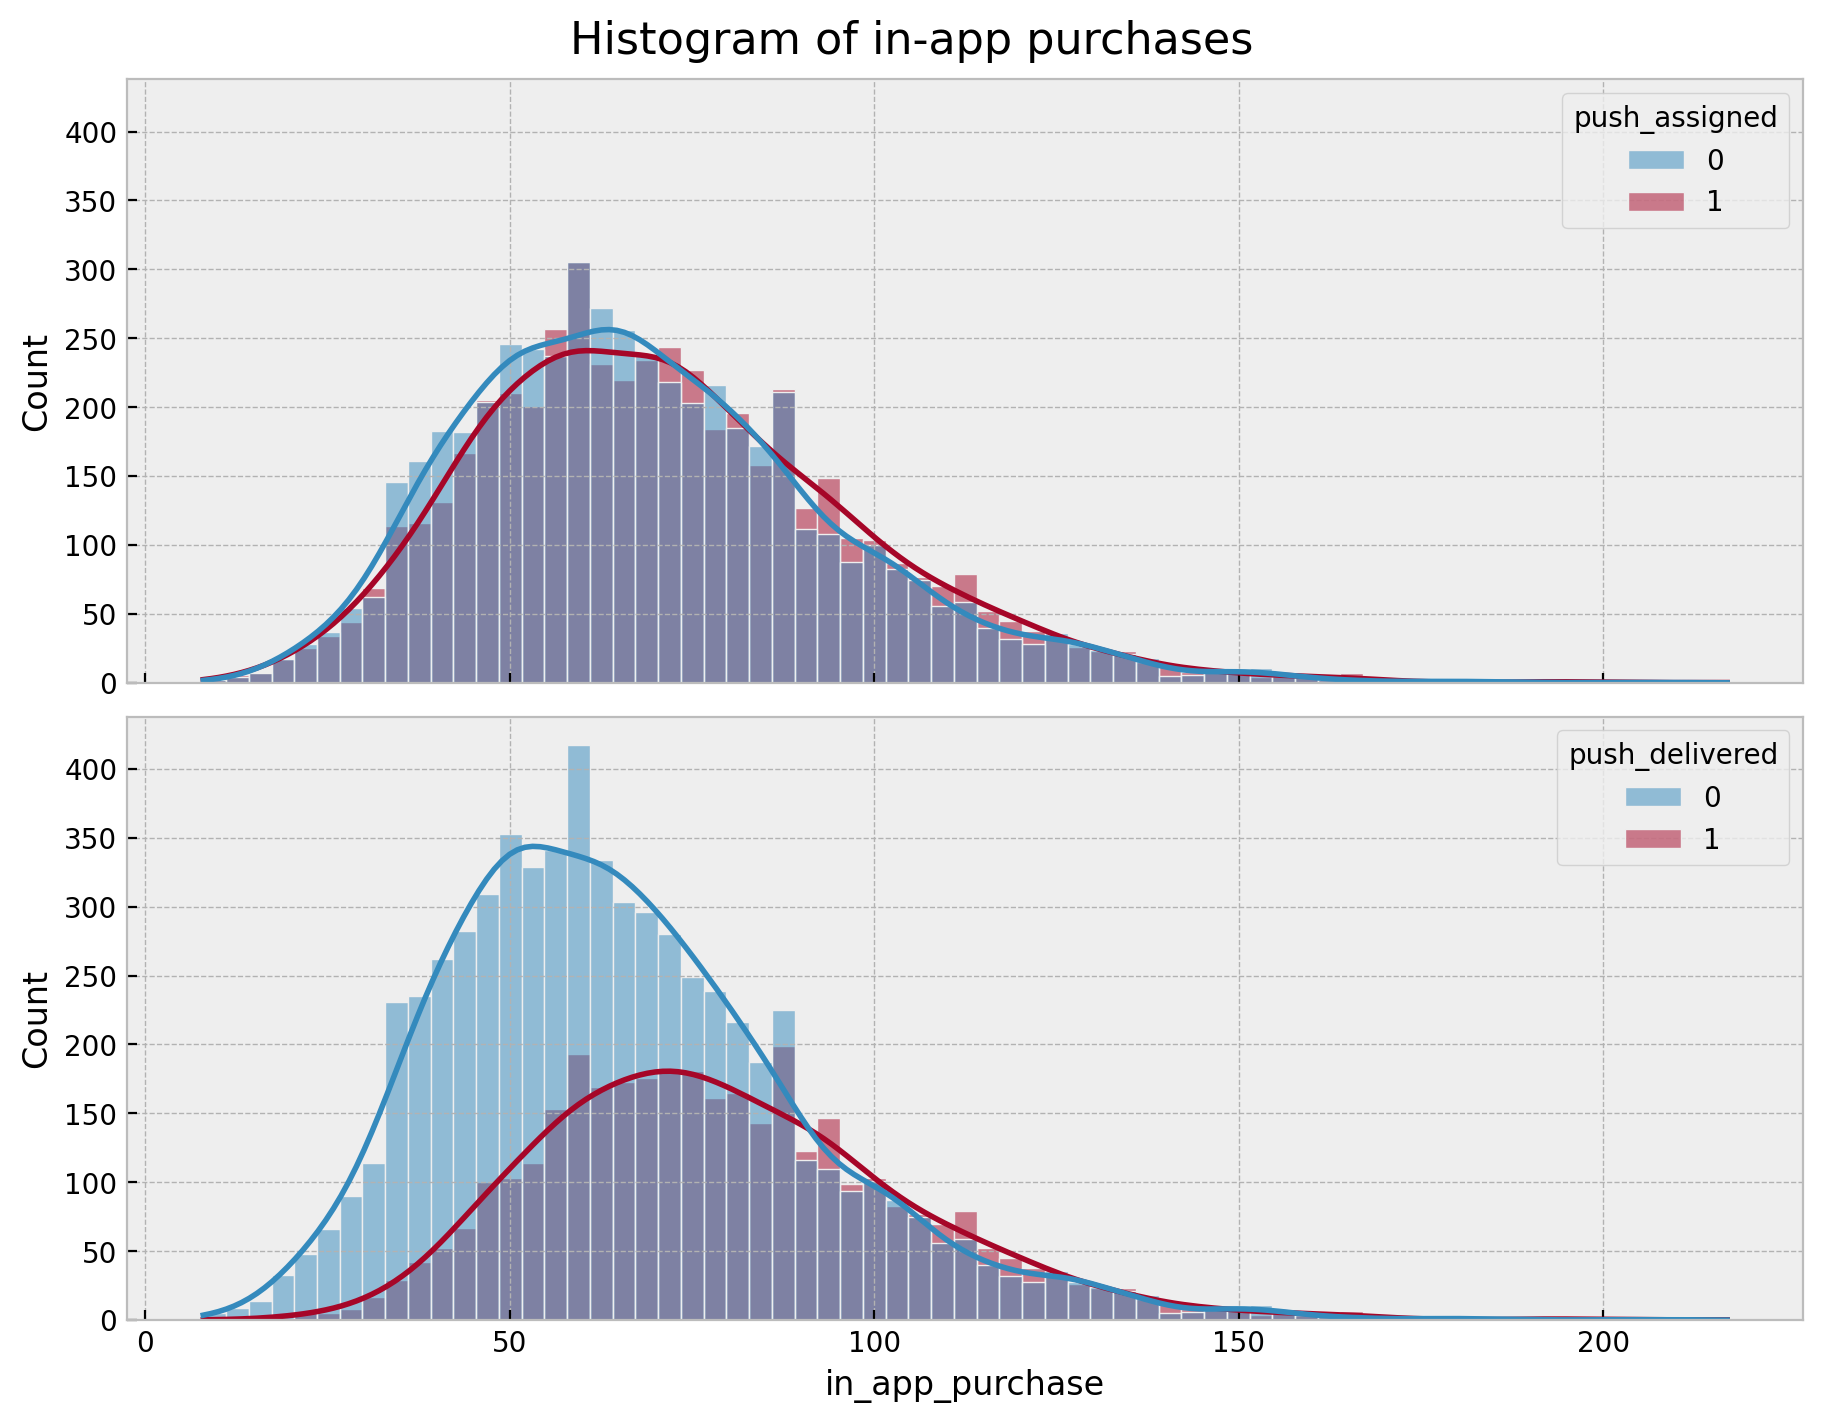

In [6]:
fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(9, 7), sharex=True, sharey=True, layout="constrained"
)
sns.histplot(x="in_app_purchase", hue="push_assigned", kde=True, data=df, ax=ax[0])
sns.histplot(x="in_app_purchase", hue="push_delivered", kde=True, data=df, ax=ax[1])
fig.suptitle("Histogram of in-app purchases", fontsize=16);

We clearly see the difference! When filtering for users that received the push notification we see higher values of `in_app_purchase` than the users in the assignment group.

## OLS Approach

Let's take the last plot as a starting point for a more quantitative analysis. We are going to run an OLS regression to estimate the effect of the push notification on purchases.

### Push Assigned Group

We start with the assignment group. First, we simply compute some statistics.

In [7]:
df.groupby("push_assigned").agg({"in_app_purchase": ["mean", "std"]})

in_app_purchase           
                         mean        std
push_assigned                           
0                   69.291675  25.771624
1                   71.655270  26.310248

The average difference seems relatively small. We can quantify it through and OLS regression.

In [8]:
ols_formula = "in_app_purchase ~ 1 + push_assigned"
ols = IV2SLS.from_formula(formula=ols_formula, data=df).fit()
ols.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
Intercept,69.292,0.3624,191.22,0.0000,68.581,70.002
push_assigned,2.3636,0.5209,4.5376,0.0000,1.3427,3.3845


The estimates effect is $2.36$ with a $95\%$ confidence interval of $[1.34, 3.38]$.

### Push Received Group

We run a a similar analysis for users that received the push notification.

In [9]:
df.groupby("push_delivered").agg({"in_app_purchase": ["mean", "std"]})

in_app_purchase           
                          mean        std
push_delivered                           
0                    65.518519  25.111324
1                    79.449958  25.358723

In [10]:
ols_formula = "in_app_purchase ~ 1 + push_delivered"
ols = IV2SLS.from_formula(formula=ols_formula, data=df).fit()
ols.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
Intercept,65.519,0.3126,209.61,0.0000,64.906,66.131
push_delivered,13.931,0.5282,26.377,0.0000,12.896,14.967


The estimate effect is much higher (as expected)!

We could even try to control for the assignment group by including it as a covariate in the regression.

In [11]:
ols_formula = "in_app_purchase ~ 1 + push_assigned + push_delivered"
ols = IV2SLS.from_formula(formula=ols_formula, data=df).fit()
ols.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
Intercept,69.292,0.3624,191.22,0.0000,68.581,70.002
push_assigned,-17.441,0.5702,-30.590,0.0000,-18.559,-16.324
push_delivered,27.600,0.6124,45.069,0.0000,26.399,28.800


In this case we get a much higher effect 😒. From the book:
>*We have reasons to believe this is a biased estimate. We know that older phones are having trouble in receiving the push, so, probably, richer customers, with newer phones, are the compilers.*

In summary, the problem are the unobserved confounders that are correlated with the assignment and the outcome. We can use instrumental variables to get better estimates!

## Instrumental Variables Estimation

As described in [Chapter 9](https://matheusfacure.github.io/python-causality-handbook/09-Non-Compliance-and-LATE.html), we can use the push assignment as an instrument to control for confounders. Why is in an instrument? Well, note that the push assignment has both an effect on getting a push notification and in in-app purchases. The key point is that the effect on in-app purchases is only due through the push notification path and therefore the effect of the assignment is easy to estimate as there are no confounders (e.g. income does not have an impact on the push assignment since it was done as random). A common to use instruments as a way of estimating effect is via 2-stage regression. The `linearmodels`(https://bashtage.github.io/linearmodels/) package has a convenient implementation of this approach.

In [12]:
iv_formula = "in_app_purchase ~ 1 + [push_delivered ~ push_assigned]"
iv = IV2SLS.from_formula(formula=iv_formula, data=df).fit()
iv.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
Intercept,69.292,0.3624,191.22,0.0000,68.581,70.002
push_delivered,3.2938,0.7165,4.5974,0.0000,1.8896,4.6981


The estimated effect is $3.29$. How to interpret this effect? (again from the book):
> *We also need to remember about Local Average Treatment Effect (LATE) $3.29$ is the average causal effect on compliers. Unfortunately, we can’t say anything about those never takers. This means that we are estimating the effect on the richer segment of the population that have newer phones.*

## Bayesian Instrumental Variables Estimation

In his section we want to describe to replicate the analysis using PyMC.Again, the motivation is to extend it in a later section to add prior knowledge from previous experiments. The main references for the sections below are:
- [Bayesian Instrumental variables (with a hierarchical prior) in Stan](https://khakieconomics.github.io/2017/11/26/Bayesian_iv.html) by [Jim Savage](https://khakieconomics.github.io/about/).
- [Bayesian instrumental variables: priors and likelihoods](https://hedibert.org/wp-content/uploads/2013/12/lopes-polson-ER.pdf) by Hedibert F. Lopes and Nicholas G. Polson.

Recall that the main challenge of the problem at hand is that the errors of OLS approach are not independent of the treatment. What if we model this correlation explicitly while fitting the model? This is the idea behind the bayesian instrumental variables approach. Concretely, let's consider the structural formulation (instead of the 2-stage form). This is nothing else as a regression model with a $2$-dimensional outcome:

- We model the `in_app_purchase` ($y$) as a function of `push_delivered` (treatment) $t$  and the error term $\varepsilon_y$.
- Simultaneously, we model treatment as a function of `push_assigned` (instrument) $z$ and and error term $\varepsilon_t$.

W e assume that the joint distribution of the errors can be parametrized by a multi-variate normal distribution with mean zero and covariance matrix $\Sigma$.

\begin{align*}
\left(
\begin{array}{cc}
y \\
t
\end{array}
\right)
& \sim 
\text{MultiNormal}(\mu, \Sigma) \\
\mu & = \left(
\begin{array}{cc}
\mu_{y} \\
\mu_{t}
\end{array}
\right)
=
\left(
\begin{array}{cc}
\beta_{t}t + a_{y} \\
\beta_{z}z + a_{t}
\end{array}
\right)
\end{align*}

We choose fairly uninformative priors (while still constraining them to plausible values) for the parameters. We use the [`LKJCholeskyCov`](https://www.pymc.io/projects/docs/en/stable/api/distributions/generated/pymc.LKJCholeskyCov.html) distribution to model the covariance matrix.

In [13]:
# Prepare data
y = df["in_app_purchase"].to_numpy()
t = df["push_delivered"].to_numpy()
z = df["push_assigned"].to_numpy()

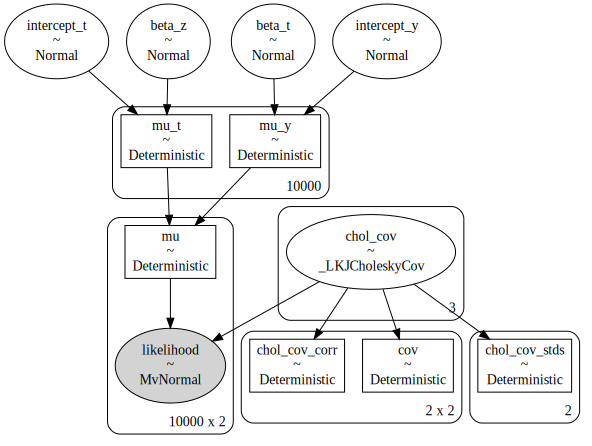

In [14]:
with pm.Model() as model:
    # --- Priors ---
    intercept_y = pm.Normal(name="intercept_y", mu=50, sigma=10)
    intercept_t = pm.Normal(name="intercept_t", mu=0, sigma=1)
    beta_t = pm.Normal(name="beta_t", mu=0, sigma=10)
    beta_z = pm.Normal(name="beta_z", mu=0, sigma=10)
    sd_dist = pm.HalfCauchy.dist(beta=2, shape=2)
    chol, corr, sigmas = pm.LKJCholeskyCov(name="chol_cov", eta=2, n=2, sd_dist=sd_dist)
    # compute and store the covariance matrix
    pm.Deterministic(name="cov", var=pt.dot(l=chol, r=chol.T))

    # --- Parameterization ---
    mu_y = pm.Deterministic(name="mu_y", var=beta_t * t + intercept_y)
    mu_t = pm.Deterministic(name="mu_t", var=beta_z * z + intercept_t)
    mu = pm.Deterministic(name="mu", var=pt.stack(tensors=(mu_y, mu_t), axis=1))

    # --- Likelihood ---
    likelihood = pm.MvNormal(
        name="likelihood",
        mu=mu,
        chol=chol,
        observed=np.stack(arrays=(y, t), axis=1),
        shape=(n, 2),
    )

pm.model_to_graphviz(model=model)

Now we fit the model.

In [15]:
with model:
    idata = pm.sampling_jax.sample_numpyro_nuts(draws=4_000, chains=4, random_seed=rng)

Compiling...
Compilation time =  0:00:05.104545
Sampling...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Sampling time =  0:00:46.503144
Transforming variables...
Transformation time =  0:00:10.276537


Let's inspect the posterior distributions of the parameters.

In [16]:
var_names = ["beta_t", "beta_z", "intercept_y", "intercept_t"]

az.summary(data=idata, var_names=var_names)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_t,3.340,0.722,1.975,4.682,0.009,0.006,6493.0,9732.0,1.0
beta_z,0.718,0.006,0.705,0.729,0.000,0.000,10286.0,11549.0,1.0
intercept_y,69.262,0.363,68.590,69.939,0.004,0.003,7635.0,11097.0,1.0
intercept_t,-0.000,0.004,-0.009,0.008,0.000,0.000,11250.0,12108.0,1.0


Note that we have recovered a very similar result as in the 2-stage approach above 🚀 ! Next we look into the traces.

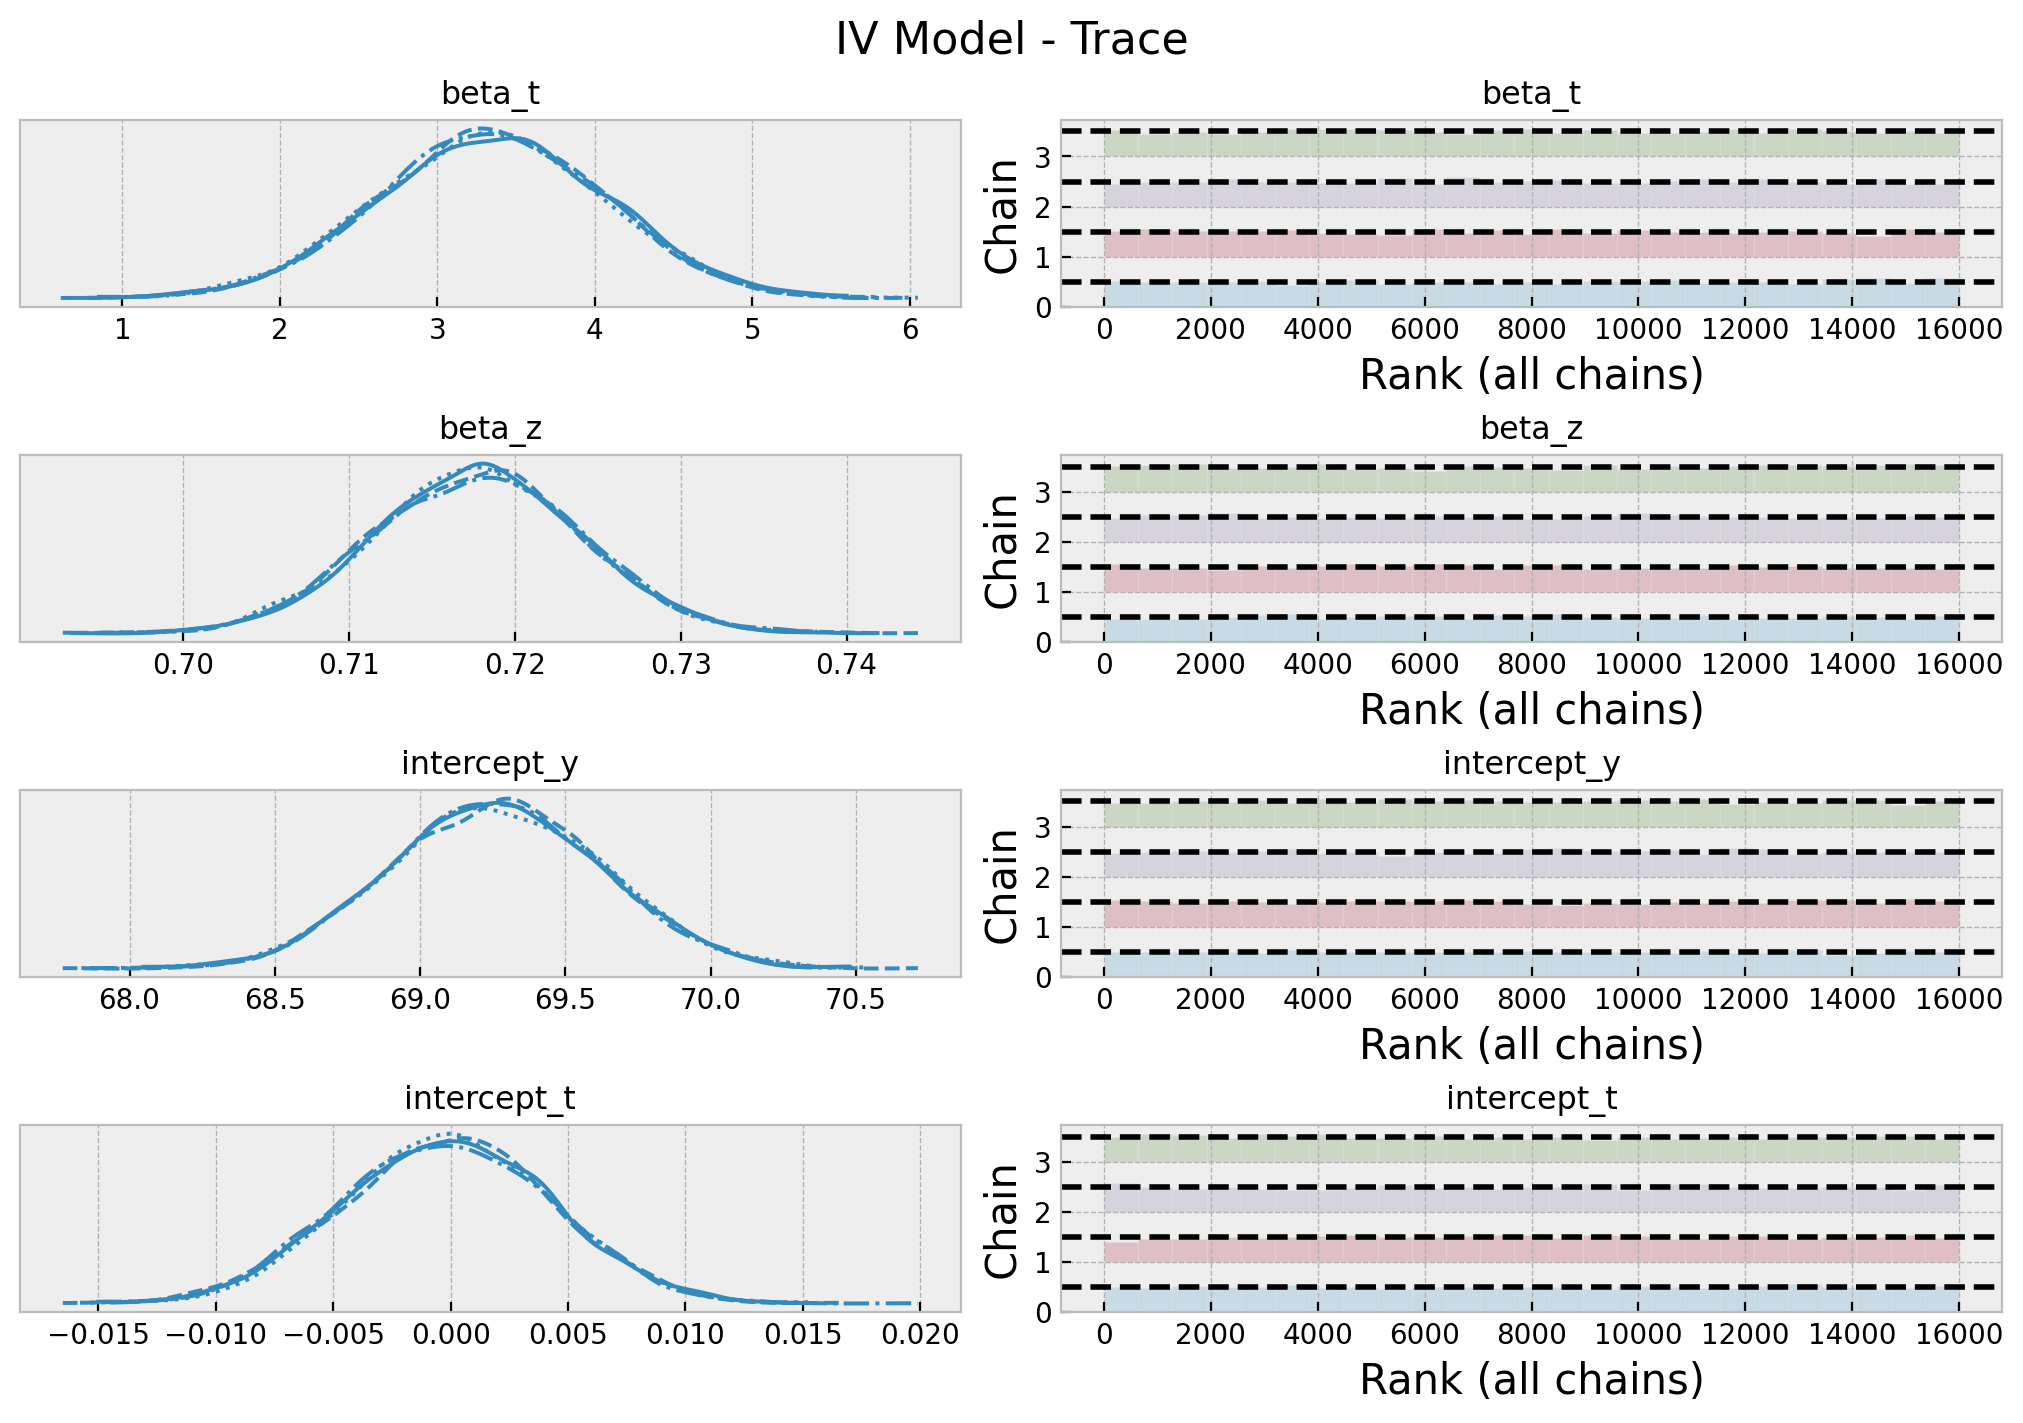

In [17]:
axes = az.plot_trace(
    data=idata,
    var_names=var_names,
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (10, 7), "layout": "constrained"},
)
plt.gcf().suptitle("IV Model - Trace", fontsize=16);

Everything looks good! Let's look deeper into the posterior distribution of the effect estimation $\beta_{t}$. In particular, we can compare the $94%$ HDI of the posterior distribution with the $94\%$ confidence interval of the 2-stage approach.

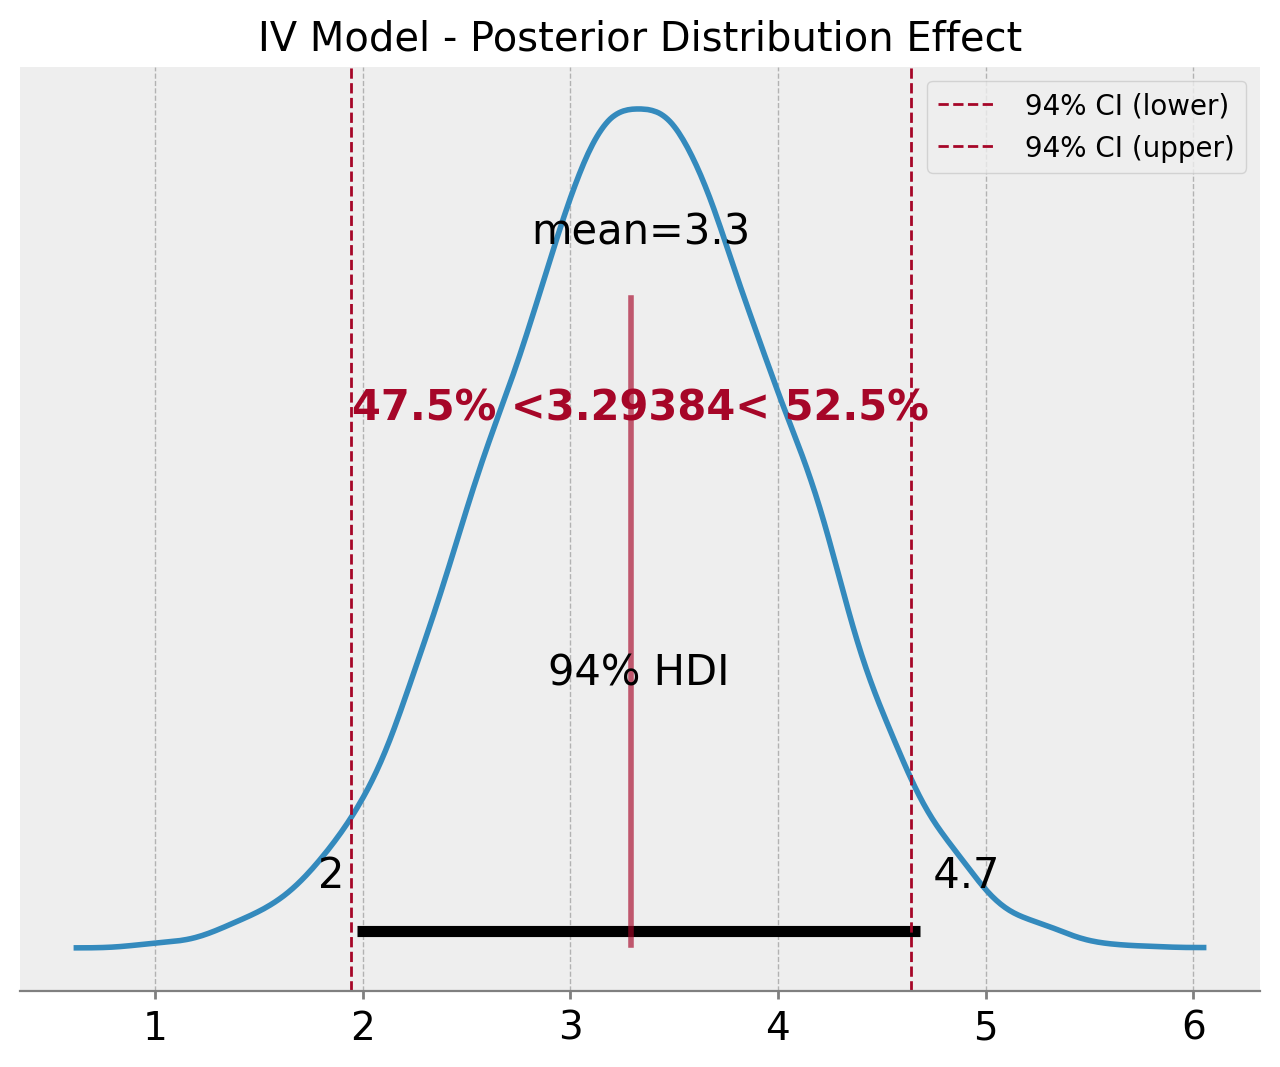

In [18]:
fig, ax = plt.subplots(figsize=(8, 6))
hdi_prob = 0.94
az.plot_posterior(
    data=idata,
    var_names=["beta_t"],
    ref_val=iv.params["push_delivered"],
    hdi_prob=hdi_prob,
    ax=ax,
)
ax.axvline(
    x=iv.conf_int(level=hdi_prob).loc["push_delivered", "lower"],
    color="C1",
    ls="--",
    lw=1,
    label=f"{hdi_prob: .0%} CI (lower)",
)
ax.axvline(
    x=iv.conf_int(level=hdi_prob).loc["push_delivered", "upper"],
    color="C1",
    ls="--",
    lw=1,
    label=f"{hdi_prob: .0%} CI (upper)",
)
ax.legend()
ax.set(title="IV Model - Posterior Distribution Effect");

The results are very similar!

In addition, we can also get the correlation of the treatment and the errors from the OLS approach.

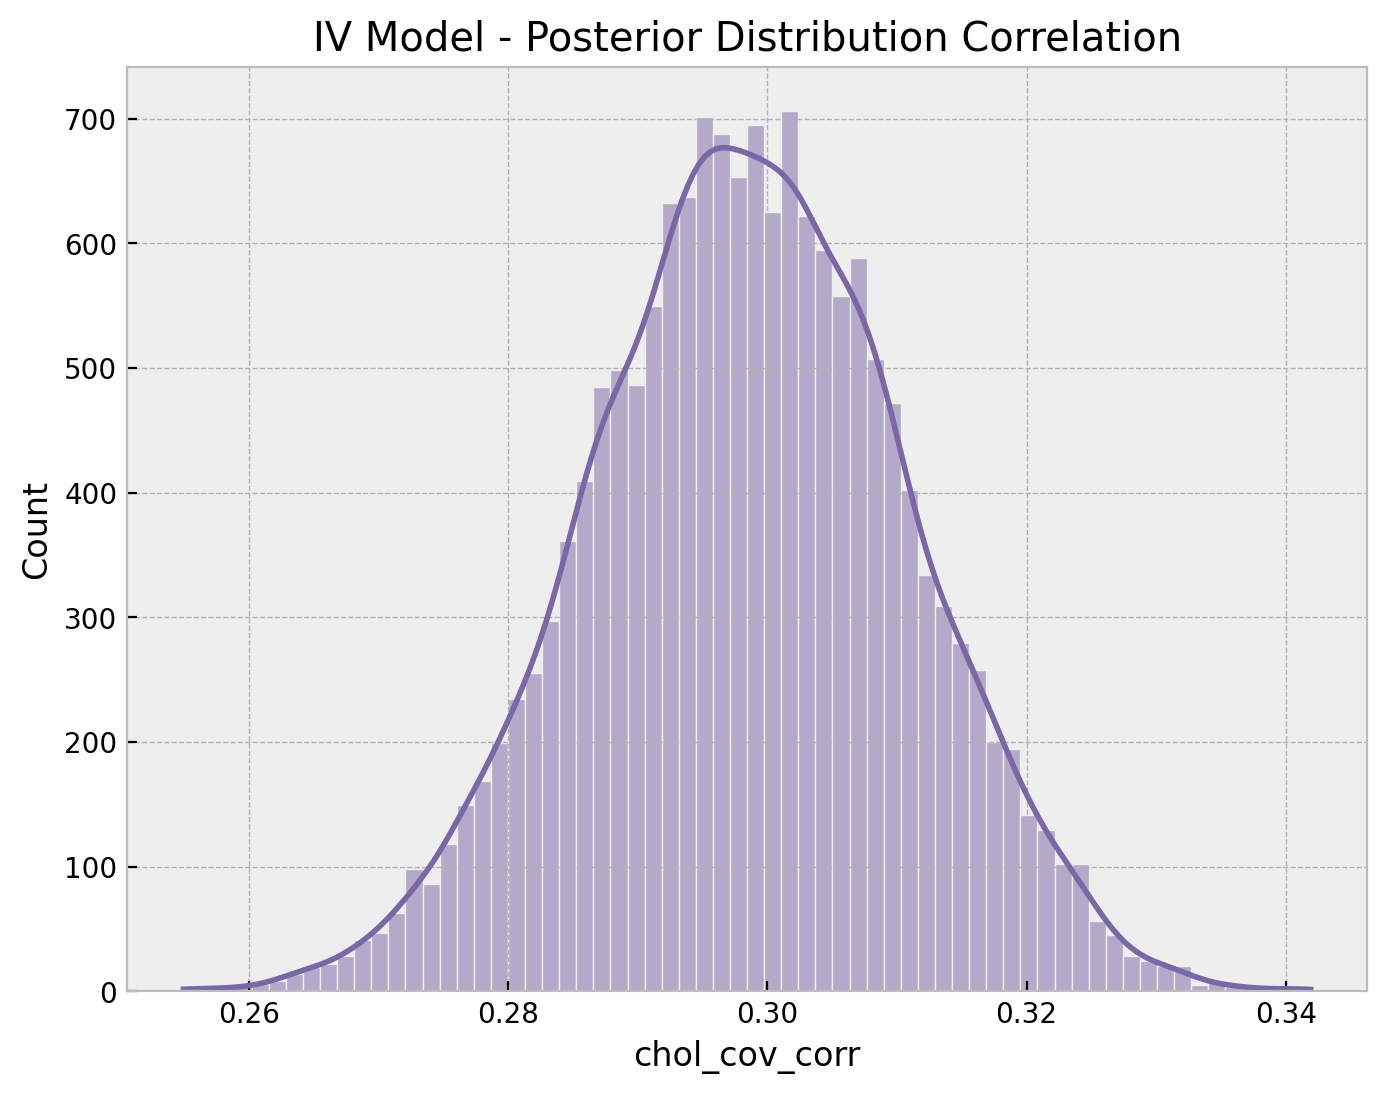

In [19]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.histplot(
    x=az.extract(data=idata, var_names=["chol_cov_corr"])[0, 1, :],
    kde=True,
    color="C2",
    ax=ax,
)
ax.set(title="IV Model - Posterior Distribution Correlation");

The correlation is around $0.3$, which is definitively not negligible. Finally, we can look into the posterior mean of the correlation matrix.

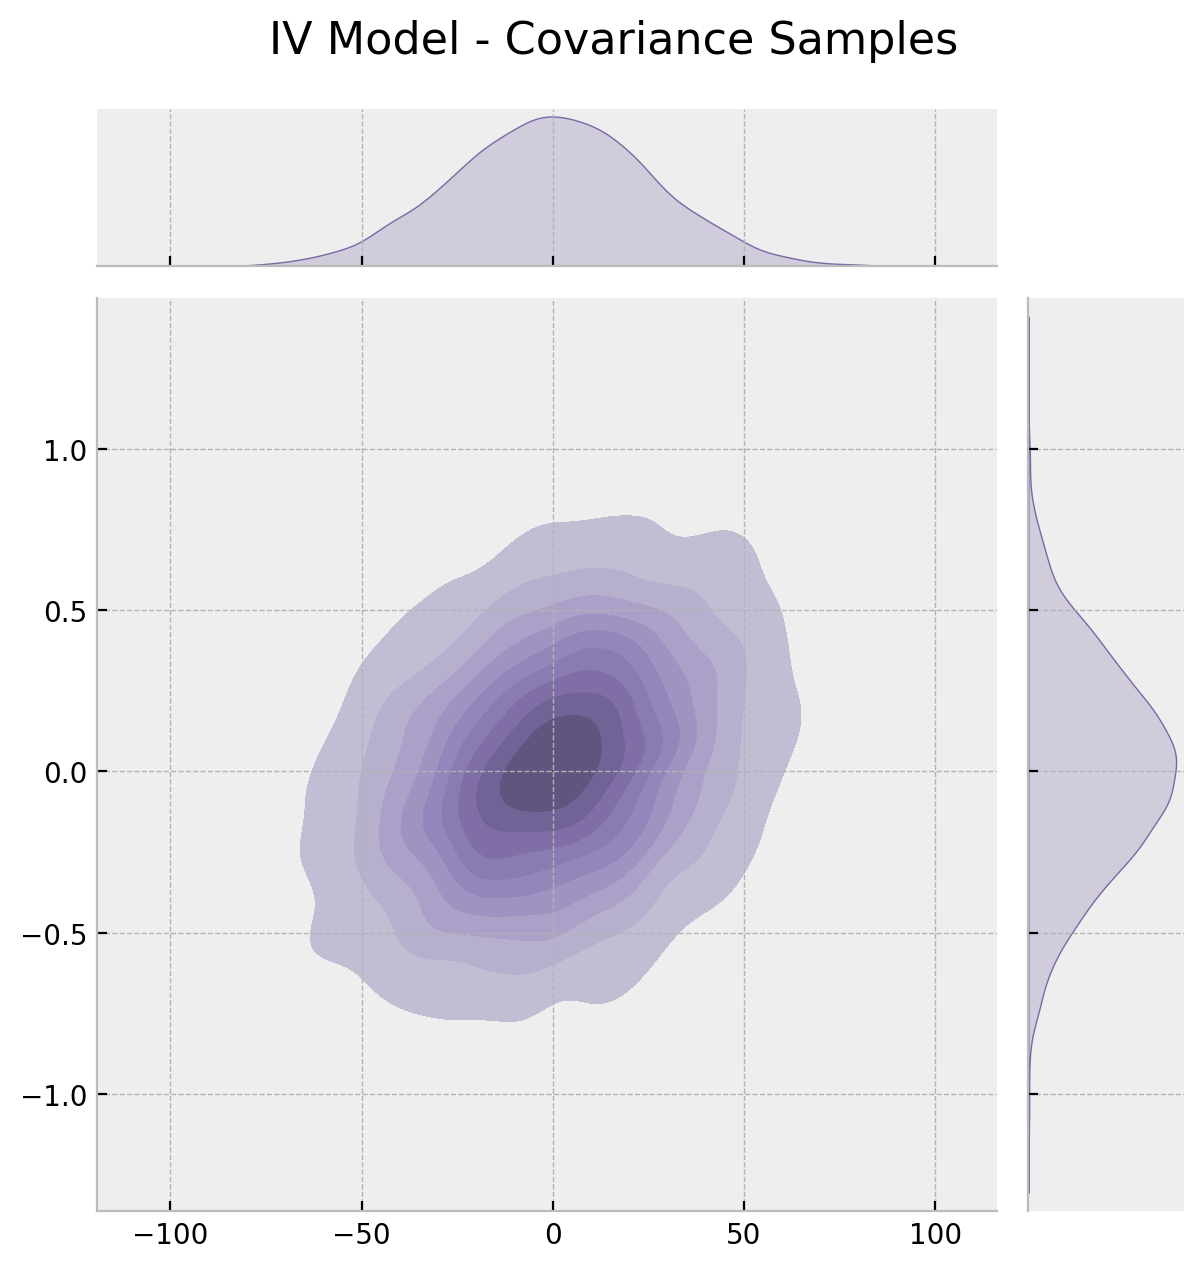

In [29]:
cov_mean = idata.posterior["cov"].mean(dim=("chain", "draw"))

cov_samples = np.random.multivariate_normal(
    mean=np.zeros(shape=(2)), cov=cov_mean, size=5_000
)

g = sns.jointplot(
    x=cov_samples[:, 0],
    y=cov_samples[:, 1],
    kind="kde",
    color="C2",
    fill=True,
    height=6,
)
g.fig.suptitle("IV Model - Covariance Samples", fontsize=16, y=1.05);

All of these results are consistent wih the discussion regarding the positive bias when filtering for users which received the push notification as a result of unobserved confounders like income.

## Hierarchical Model: Adding past experiments as priors

Now, we look into a very interesting extension. Imagine we have access to previous experiments results (not-uncommon in the tech industry) where we have the med effects $b_j$ and the corresponding standard errors $\sigma_{j}$. We would like to pass this information to the model as trough the prior distributions. One approach suggested in the great post [Bayesian Instrumental variables (with a hierarchical prior) in Stan](https://khakieconomics.github.io/2017/11/26/Bayesian_iv.html) by [Jim Savage](https://khakieconomics.github.io/about/) is t use a hierarchical model to include there previous experiments. The idea is to have a "hyper-prior" distribution $\text{Normal}(\bar{\beta}_{t}, \bar{\sigma}_{t})$ so that

\begin{align*}
\beta_j & \sim \text{Normal}(\bar{\beta}_{t}, \bar{\sigma}_{t}) \\
b_j  & \sim \text{Normal}(\bar{\beta}, \sigma_{j})
\end{align*}

so that the current treatment effect has as a prior $\beta_t \sim \text{Normal}(\bar{\beta}_{t}, \bar{\sigma}_{t})$. The PyMC implementation is fairly similar to the base case. One thing to consider in the hierarchical model is that we need to use a non-centered parametrization  to make the sampling more efficient (see the example [A Primer on Bayesian Methods for Multilevel Modeling](https://www.pymc.io/projects/examples/en/latest/case_studies/multilevel_modeling.html#non-centered-parameterization) for implementation details).

In [21]:
# previous experiment data
b_j = np.array([3.4, 3.6, 4.25, 4.0, 3.9])
se_j = np.array([0.5, 0.55, 0.6, 0.45, 0.44])

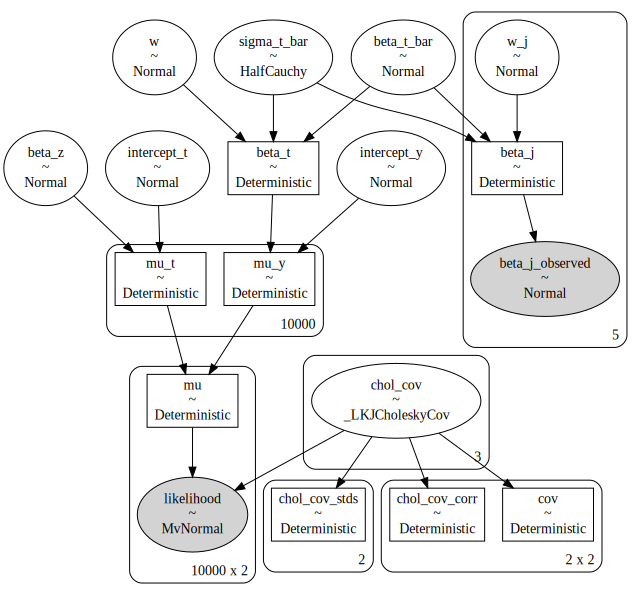

In [22]:
with pm.Model() as hierarchical_model:
    # --- Priors ---
    beta_t_bar = pm.Normal(name="beta_t_bar", mu=4, sigma=2)
    sigma_t_bar = pm.HalfCauchy(name="sigma_t_bar", beta=2)

    intercept_y = pm.Normal(name="intercept_y", mu=50, sigma=10)
    intercept_t = pm.Normal(name="intercept_t", mu=0, sigma=1)

    beta_z = pm.Normal(name="beta_z", mu=0, sigma=10)
    sd_dist = pm.HalfCauchy.dist(beta=2, shape=2)
    chol, corr, sigmas = pm.LKJCholeskyCov(name="chol_cov", eta=2, n=2, sd_dist=sd_dist)
    # compute and store the covariance matrix
    pm.Deterministic(name="cov", var=pt.dot(l=chol, r=chol.T))

    # --- Parameterization ---
    # previous experiment model
    # set standard normals to use in the non-centered parameterization
    w_j = pm.Normal(name="w_j", mu=0, sigma=1, shape=b_j.size)
    beta_j = pm.Deterministic(name="beta_j", var=beta_t_bar + sigma_t_bar * w_j)
    pm.Normal(name="beta_j_observed", mu=beta_j, sigma=se_j, observed=b_j)
    
    # current experiment model
    # set standard normals to use in the non-centered parameterization
    w = pm.Normal(name="w", mu=0, sigma=1)
    beta_t = pm.Deterministic(name="beta_t", var=beta_t_bar + sigma_t_bar * w)
    
    mu_y = pm.Deterministic(name="mu_y", var=beta_t * t + intercept_y)
    mu_t = pm.Deterministic(name="mu_t", var=beta_z * z + intercept_t)
    mu = pm.Deterministic(name="mu", var=pt.stack(tensors=(mu_y, mu_t), axis=1))
    
    # --- Likelihood ---
    likelihood = pm.MvNormal(
        name="likelihood",
        mu=mu,
        chol=chol,
        observed=np.stack(arrays=(y, t), axis=1),
        shape=(n, 2),
    )

pm.model_to_graphviz(model=hierarchical_model)

We sample from the model (it takes a bit longer than the previous one).

In [23]:
with hierarchical_model:
    hierarchical_idata = pm.sampling_jax.sample_numpyro_nuts(
        target_accept=0.95, draws=4_000, chains=4, random_seed=rng
    )

Compiling...
Compilation time =  0:00:05.369728
Sampling...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Sampling time =  0:02:09.306974
Transforming variables...
Transformation time =  0:00:15.078521


In [24]:
# verify we do not have divergences
print(f"Divergences = {hierarchical_idata.sample_stats.diverging.sum().item()}")

Divergences = 0


We now look into the posterior distributions of the parameters.

In [25]:
var_names = [
    "beta_t_bar",
    "sigma_t_bar",
    "beta_t",
    "beta_z",
    "intercept_y",
    "intercept_t",
]

az.summary(data=hierarchical_idata, var_names=var_names)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_t_bar,3.776,0.262,3.278,4.275,0.003,0.002,8943.0,7629.0,1.0
sigma_t_bar,0.302,0.271,0.000,0.771,0.003,0.002,6148.0,6112.0,1.0
beta_t,3.709,0.363,2.990,4.398,0.004,0.003,10025.0,9744.0,1.0
beta_z,0.719,0.006,0.707,0.730,0.000,0.000,14523.0,12656.0,1.0
intercept_y,69.132,0.287,68.581,69.671,0.003,0.002,12511.0,10777.0,1.0
intercept_t,-0.001,0.004,-0.009,0.007,0.000,0.000,14341.0,12822.0,1.0


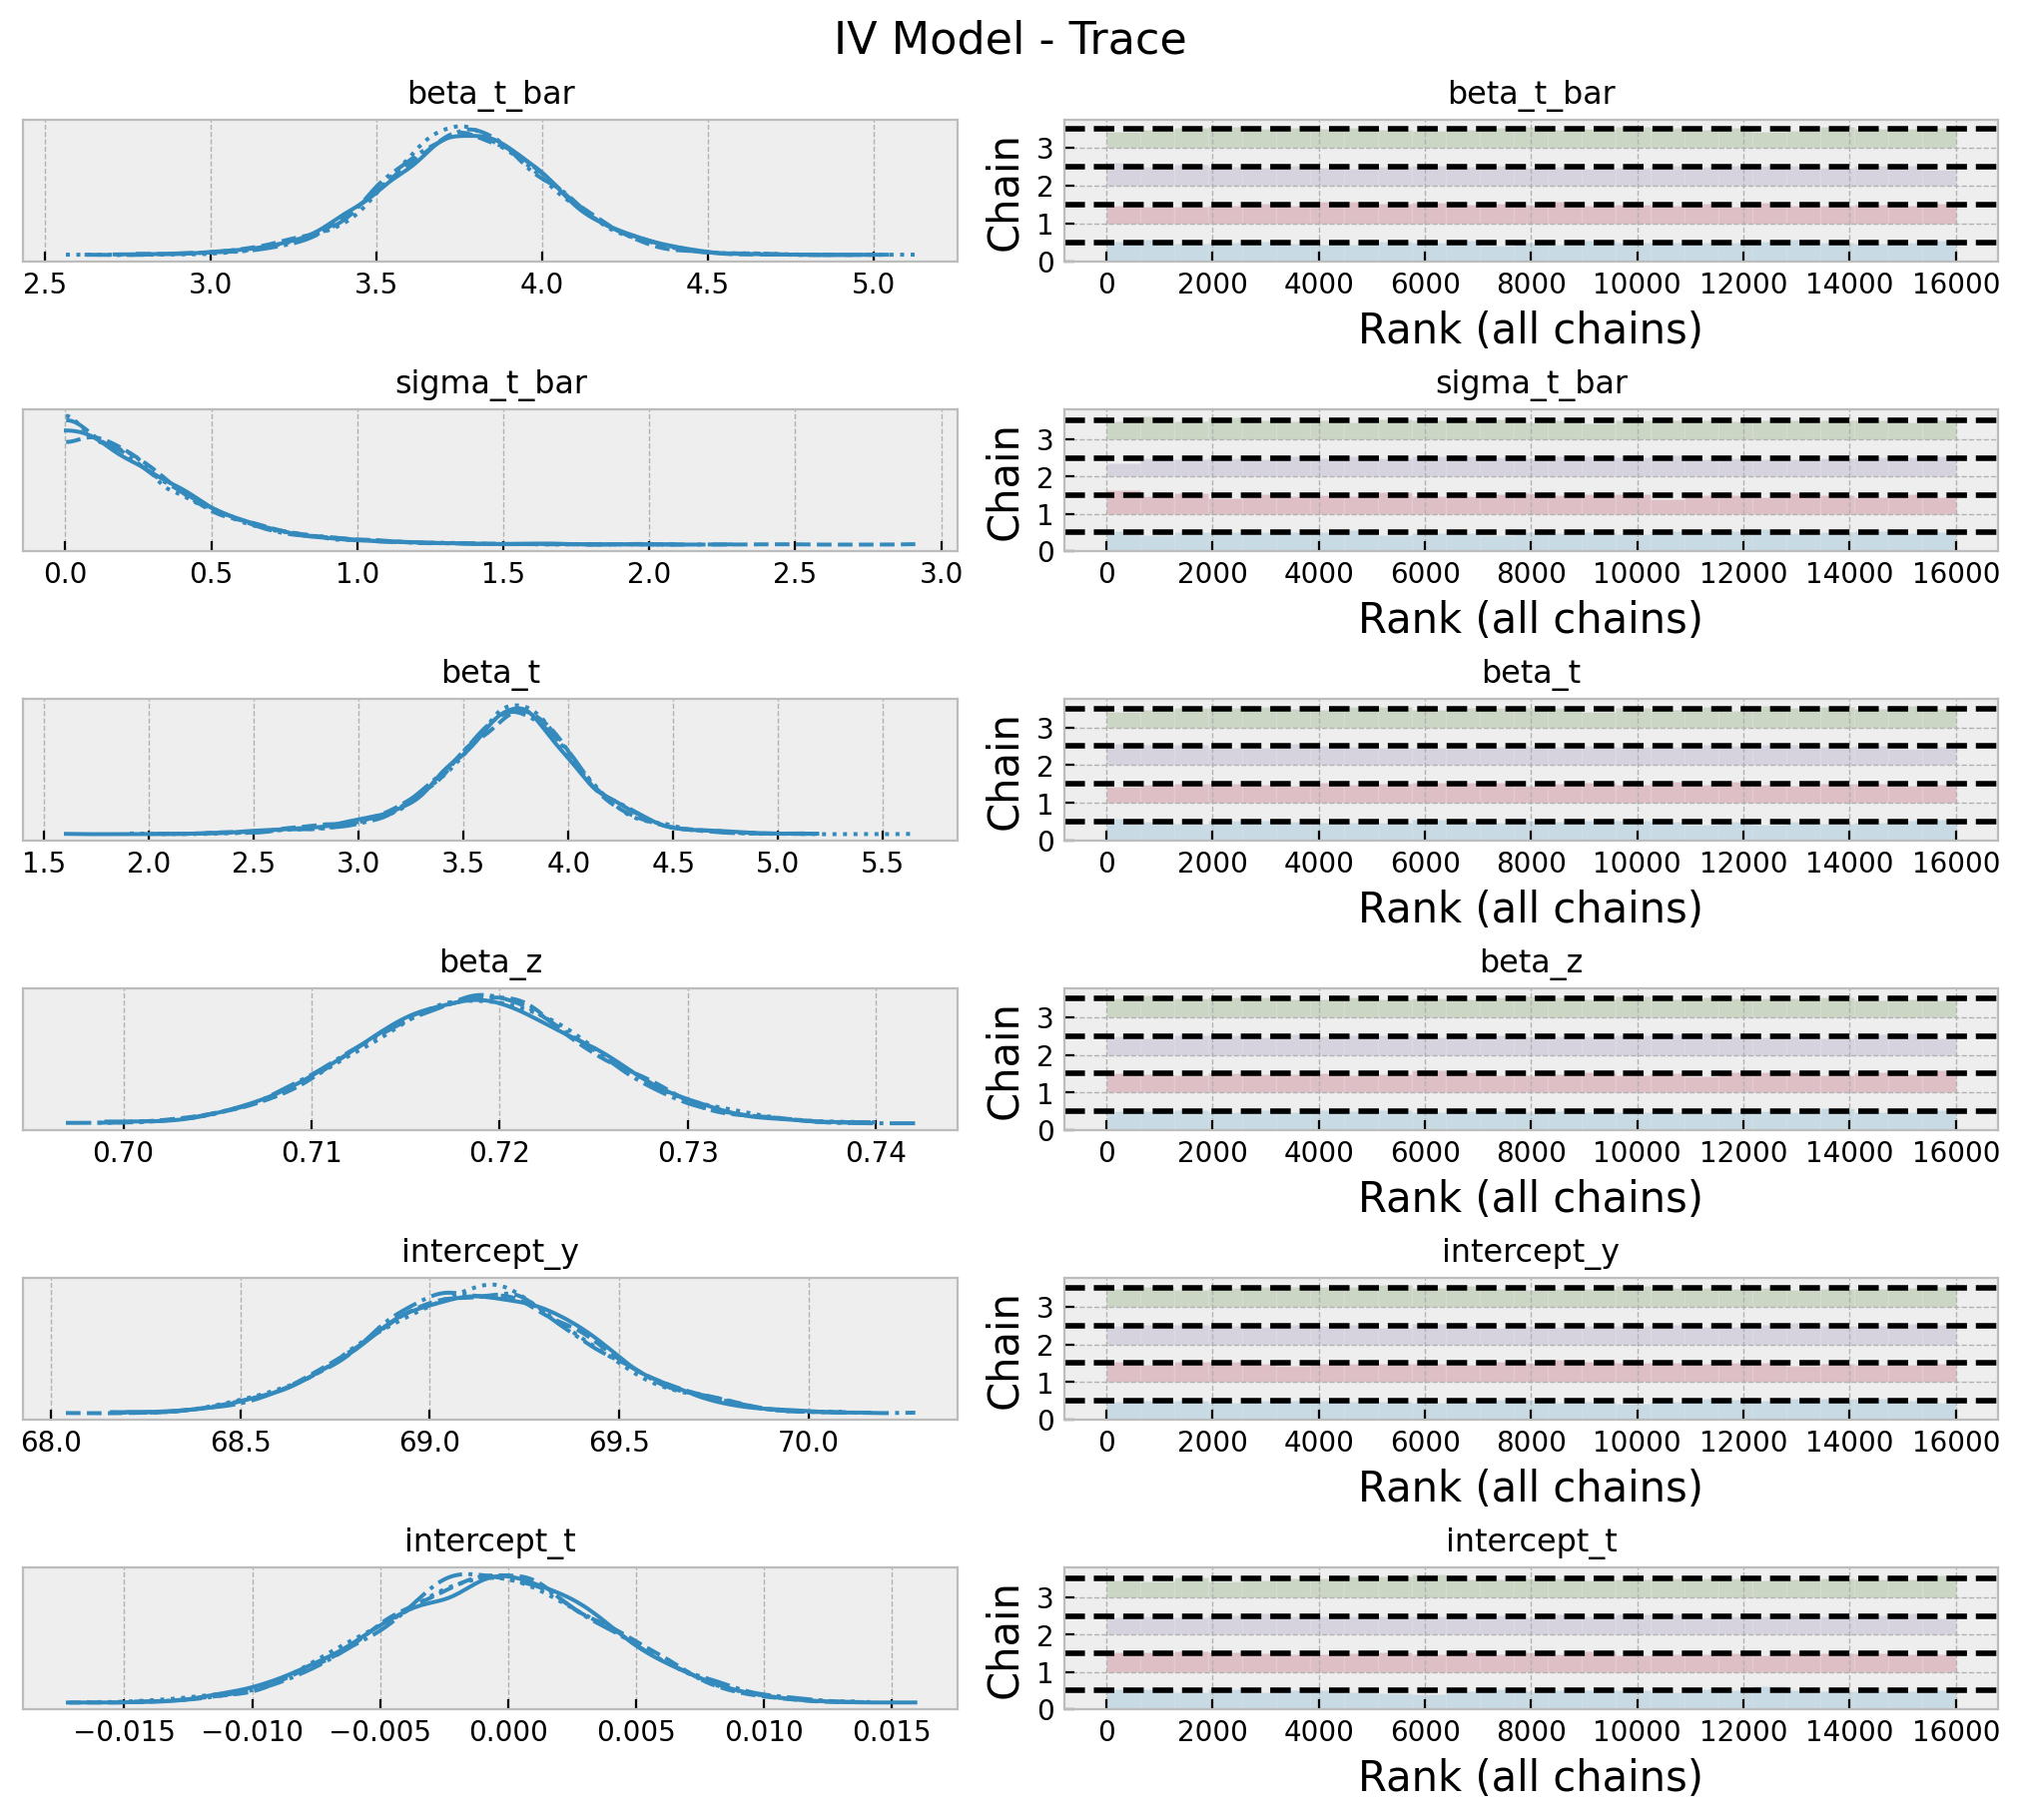

In [26]:
axes = az.plot_trace(
    data=hierarchical_idata,
    var_names=var_names,
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (10, 9), "layout": "constrained"},
)
plt.gcf().suptitle("IV Model - Trace", fontsize=16);

Note that the estimated effect is now $3.77$, which is higher than the previous case as it is using the prior information from the previous experiments. Let's zoom in into the posterior distribution of the effect.

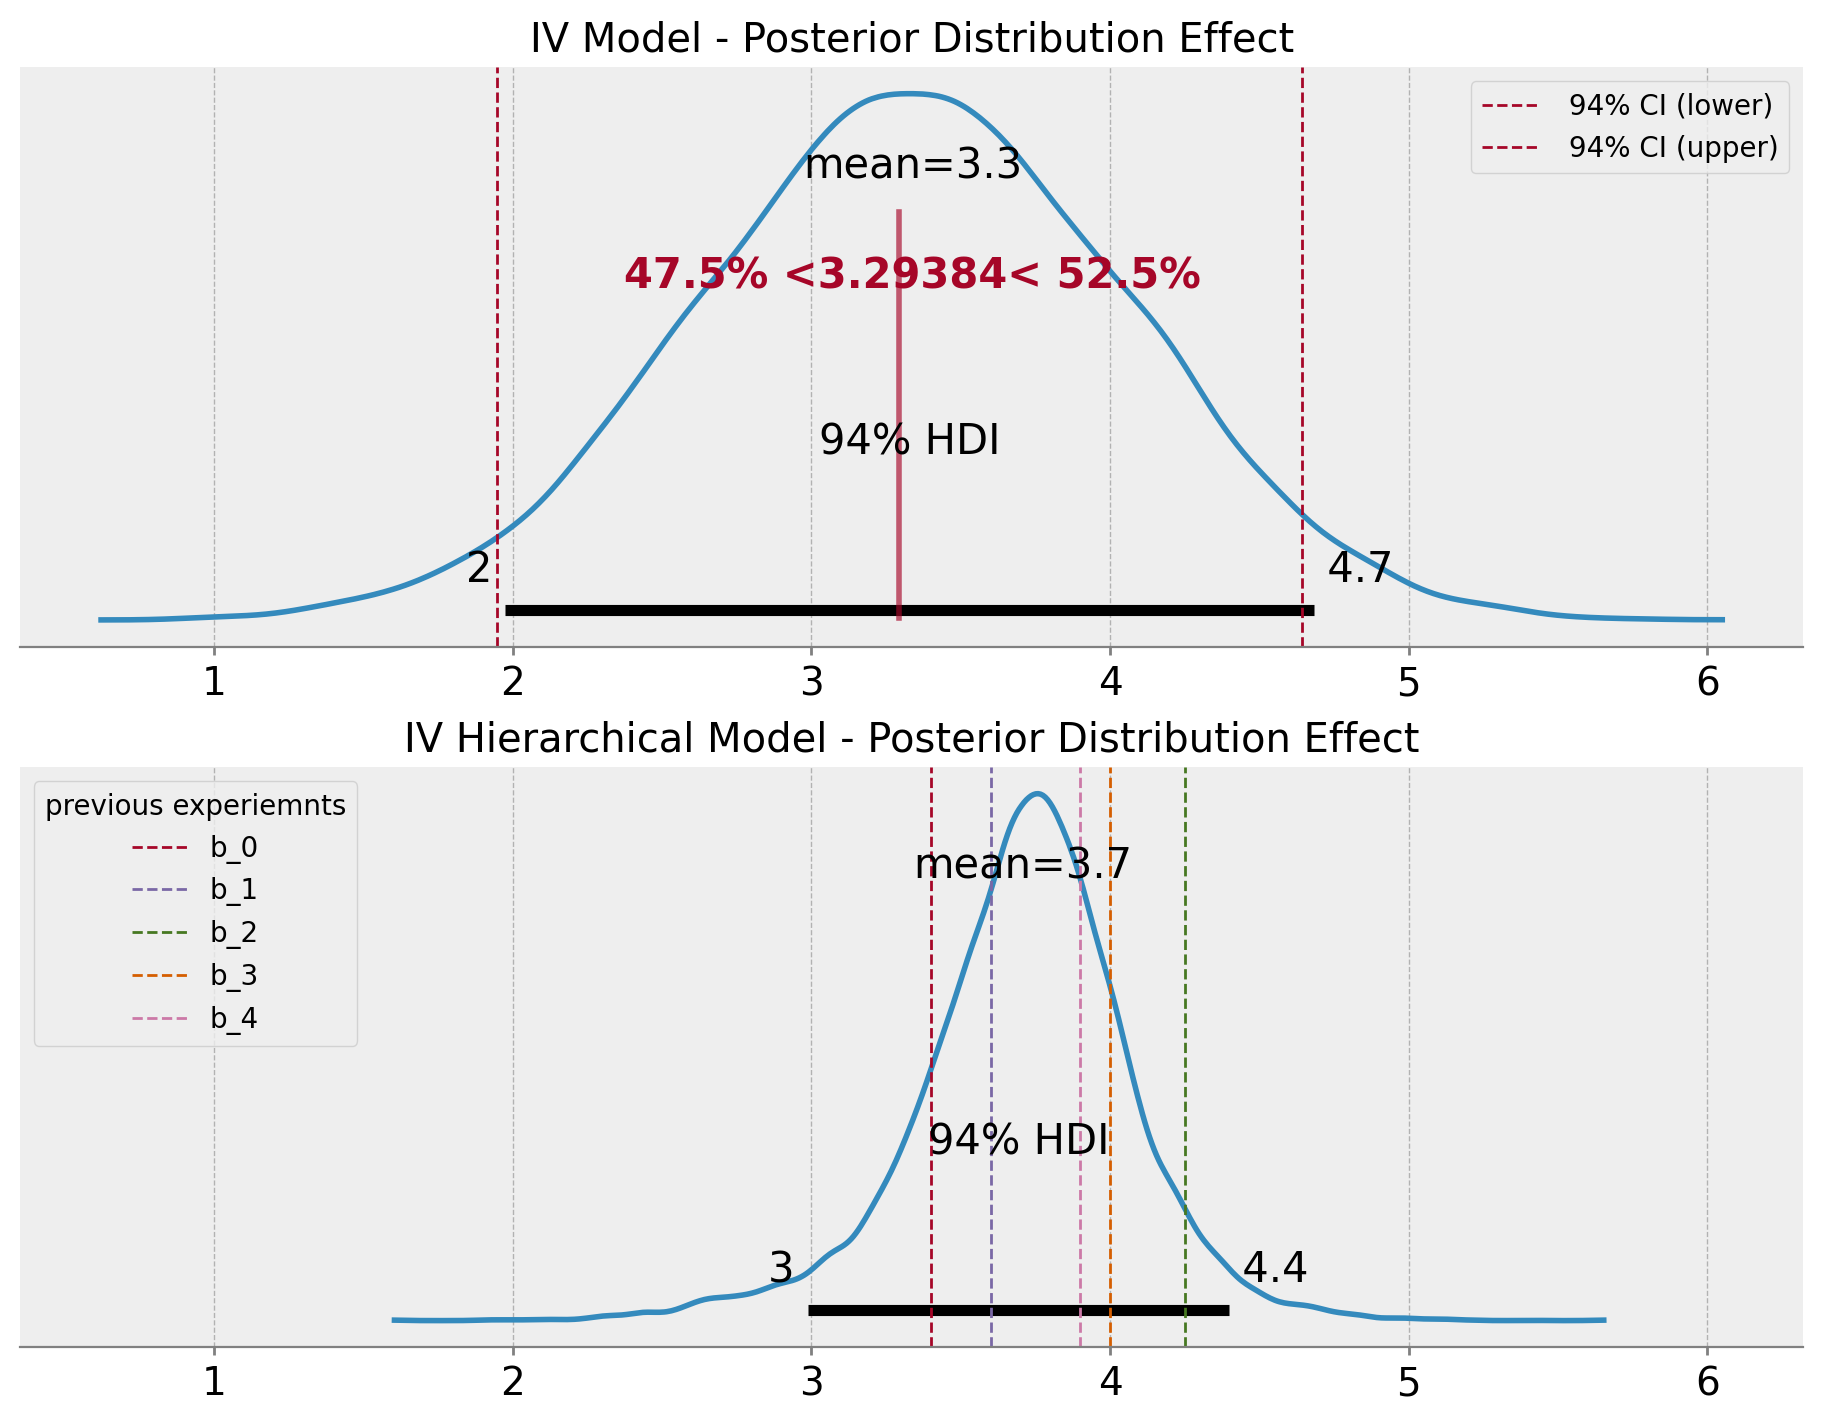

In [27]:
fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(9, 7), sharex=True, sharey=False, layout="constrained"
)
hdi_prob = 0.94

az.plot_posterior(
    data=idata,
    var_names=["beta_t"],
    ref_val=iv.params["push_delivered"],
    hdi_prob=hdi_prob,
    ax=ax[0],
)
ax[0].axvline(
    x=iv.conf_int(level=hdi_prob).loc["push_delivered", "lower"],
    color="C1",
    ls="--",
    lw=1,
    label=f"{hdi_prob: .0%} CI (lower)",
)
ax[0].axvline(
    x=iv.conf_int(level=hdi_prob).loc["push_delivered", "upper"],
    color="C1",
    ls="--",
    lw=1,
    label=f"{hdi_prob: .0%} CI (upper)",
)
ax[0].legend()
ax[0].set(title="IV Model - Posterior Distribution Effect")

az.plot_posterior(
    data=hierarchical_idata,
    var_names=["beta_t"],
    hdi_prob=hdi_prob,
    ax=ax[1],

)

for j, (b, se) in enumerate(zip(b_j, se_j)):
    ax[1].axvline(x=b, color=f"C{j + 1}", ls="--", lw=1, label=f"b_{j}")

ax[1].legend(title="previous experiemnts", loc="upper left")
ax[1].set(title="IV Hierarchical Model - Posterior Distribution Effect");

Note that the variance of the estimation is lower than the base case. This is one of the advantages of using the hierarchical model to pass prior information from previous experiments since we are also providing, the model with information about the expected uncertainty.

Finally, we can compare the posterior distribution of the effect with the hyper-prior distribution.

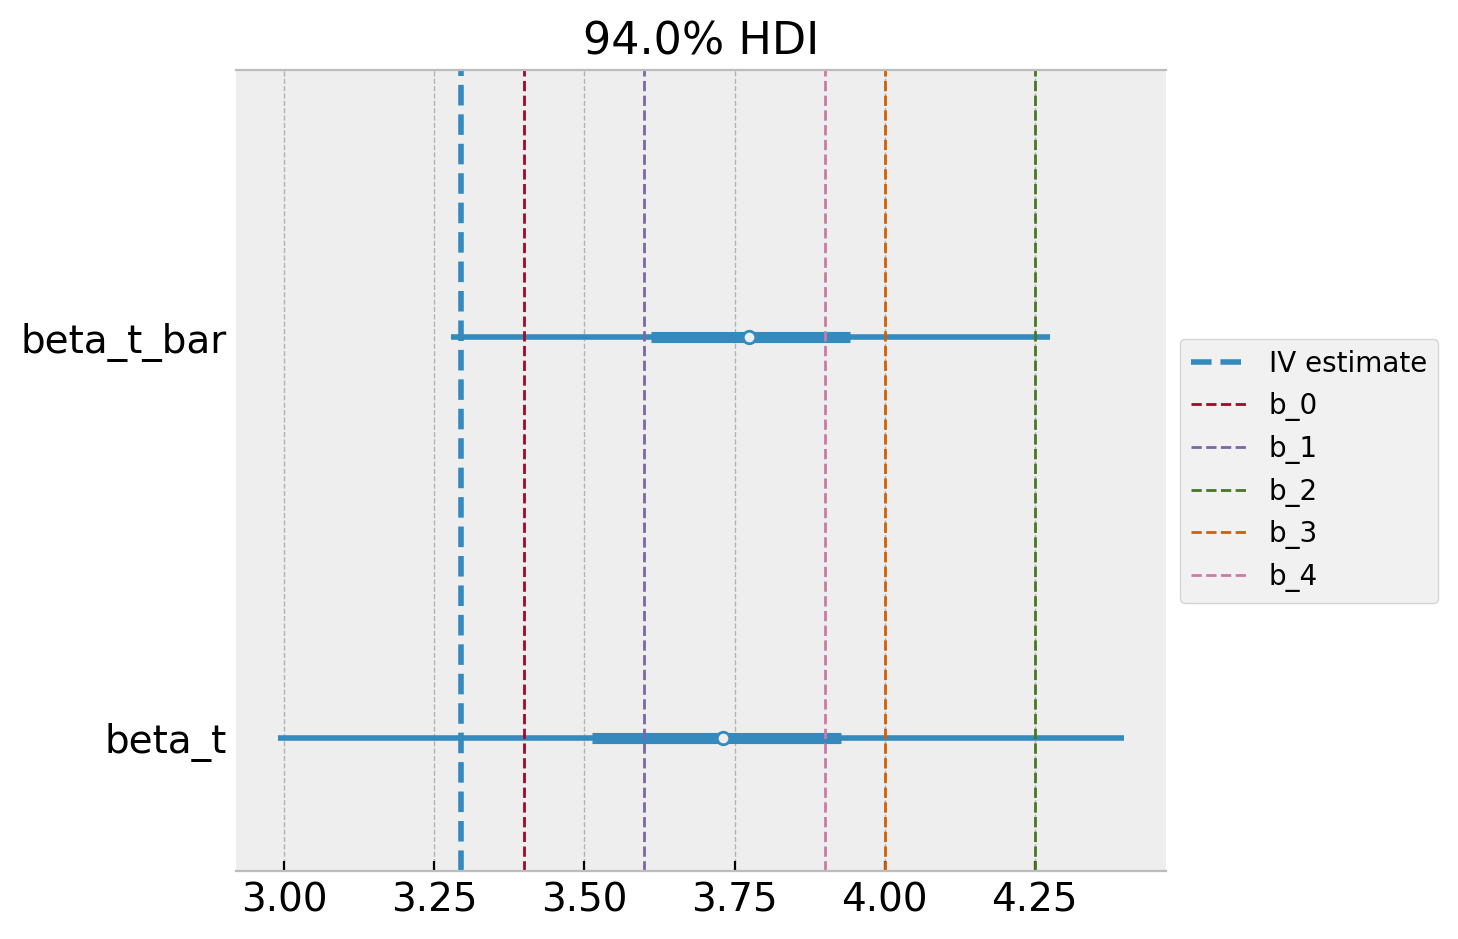

In [28]:
ax, *_ = az.plot_forest(
    data=hierarchical_idata,
    var_names=["beta_t_bar", "beta_t"],
    combined=True,
)

ax.axvline(x=iv.params["push_delivered"], color="C0", ls="--", label="IV estimate")

for j, (b, se) in enumerate(zip(b_j, se_j)):
    ax.axvline(x=b, color=f"C{j + 1}", ls="--", lw=1, label=f"b_{j}")

ax.legend(loc="center left",  bbox_to_anchor=(1, 0.5));

As expected, the posterior distribution of the effect is closer to the base case 🙂.